## To Do:
#### 1) Build model... try a few
#### 2) We're missing the current score...

#### n) Use the whole dataset to train a model to use as a prior probability to each team model.  How do we stack?  Pr(NE pass ! Conv wisdom pass)
#### n+1) Add rush L/R and pass SHORT/DEEP back in as classes

In [145]:
# typical imports
import pandas as pd
import numpy as np
import matplotlib

import random 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [98]:
pbp2015 = pd.read_csv('pbp-2015.csv')
pbp2014 = pd.read_csv('pbp-2014.csv')
#pbp2013 = pd.read_csv('pbp-2013.csv')

- Check descriptions for NaN formations --> They were timeouts or 2-min warnings
* We could bin up ToGo 1, 2-5, 6-10, 10-15, 15+
- Combine No Huddle with corresponding formations --> There's a straight 'NO HUDDLE' formation, so nothing would be left
- Combine IsRush/IsPass with other outcomes (punt, field goal, etc.) and make that the target
* Train GBC on it
* Bayesian classifier?

## EDA and Cleaning

In [99]:
for column in pbp2015:
    print column, pbp2015[column].unique()

GameId [2015091000 2015091300 2015091301 2015091302 2015091303 2015091304
 2015091305 2015091306 2015091307 2015091308 2015091309 2015091310
 2015091311 2015091312 2015091400 2015091401 2015091700 2015092000
 2015092001 2015092002 2015092003 2015092004 2015092005 2015092006
 2015092007 2015092008 2015092009 2015092010 2015092011 2015092012
 2015092013 2015092100 2015092400 2015092700 2015092701 2015092702
 2015092703 2015092704 2015092705 2015092706 2015092707 2015092708
 2015092709 2015092710 2015092711 2015092712 2015092713 2015092800
 2015100100 2015100400 2015100401 2015100402 2015100403 2015100404
 2015100405 2015100406 2015100407 2015100408 2015100409 2015100410
 2015100411 2015100412 2015100500 2015100800 2015101100 2015101101
 2015101102 2015101103 2015101104 2015101105 2015101106 2015101107
 2015101108 2015101109 2015101110 2015101111 2015101200 2015101500
 2015101800 2015101801 2015101802 2015101803 2015101804 2015101805
 2015101806 2015101807 2015101808 2015101809 2015101810

In [100]:
# drop all columns with no info
pbp2015.drop(['Unnamed: 10', 'Unnamed: 12','Unnamed: 16', 'Unnamed: 17', 'Challenger'], axis=1, inplace=True)
pbp2015.drop(['IsMeasurement', 'NextScore', 'TeamWin'], axis=1, inplace=True)

In [101]:
# drop all columns we won't use
pbp2015.drop(['IsIncomplete', 'IsTouchdown','IsSack', 'IsChallenge', 'IsChallengeReversed'], axis=1, inplace=True)
pbp2015.drop(['IsInterception', 'IsPenalty', 'IsTwoPointConversion', 'SeriesFirstDown'], axis=1, inplace=True)
pbp2015.drop(['IsTwoPointConversionSuccessful', 'IsPenaltyAccepted', 'PenaltyTeam'], axis=1, inplace=True)
pbp2015.drop(['IsFumble', 'PenaltyType', 'PenaltyYards', 'SeasonYear', 'GameId', 'GameDate'], axis=1, inplace=True)
pbp2015.drop(['IsNoPlay'], axis=1, inplace=True)

In [102]:
pbp2015.PlayType.unique()

array([nan, 'RUSH', 'PASS', 'TIMEOUT', 'PUNT', 'QB KNEEL', 'KICK OFF',
       'NO PLAY', 'SCRAMBLE', 'FIELD GOAL', 'SACK', 'EXTRA POINT',
       'TWO-POINT CONVERSION', 'EXCEPTION', 'FUMBLES', 'CLOCK STOP',
       'PENALTY'], dtype=object)

In [103]:
pbp2015.PassType.unique()

array([nan, 'DEEP MIDDLE', 'SHORT LEFT', 'SHORT RIGHT', 'SHORT MIDDLE',
       'DEEP LEFT', 'DEEP RIGHT', 'INTENDED FOR', 'RIGHT TO',
       '(6:44) (SHOTGUN)', 'LEFT TO', 'PASS RULING,', '(13:19) 5-TTAYLOR',
       'IN 119', 'INTERCEPTED BY', 'NOT LISTED', '(10:14) 17-PRIVERS',
       '(10:01) (SHOTGUN)', '[20-C.GRAHAM]. THROWN', 'MIDDLE TO',
       '[55-S.TULLOCH]. PENALTY', '(:21) 5-TBRIDGEWATER',
       '[31-M.ALEXANDER]. PENALTY', '(4:54) 2-JMANZIEL',
       '[58-V.MILLER]. THE'], dtype=object)

In [104]:
# get rid of all the kicks except punts and field goals
pbp2015 = pbp2015[(pbp2015.PlayType != 'KICK OFF') & (pbp2015.PlayType != 'EXTRA POINT') & (pbp2015.PlayType != 'TWO-POINT CONVERSION')]

# get rid of all the timeout plays
pbp2015 = pbp2015[pbp2015.OffenseTeam.notnull()]

# get rid of all of the no-plays
pbp2015 = pbp2015[(pbp2015.PlayType != 'NO PLAY') & (pbp2015.PlayType != 'EXCEPTION') & (pbp2015.PlayType != 'CLOCK STOP')& (pbp2015.PlayType != 'PENALTY')]

# get rid of all the malformed pass types
passtypes = ['DEEP MIDDLE', 'SHORT LEFT', 'SHORT RIGHT', 'SHORT MIDDLE', 'DEEP LEFT', 'DEEP RIGHT']
pbp2015 = pbp2015[(pbp2015['PassType'].isin(passtypes)) | (pbp2015['PassType'].isnull())]

# replace the nan PlayTypes with 'DIRECT SNAP' (they are...)
pbp2015.PlayType = pbp2015.PlayType.fillna('DIRECT SNAP')

In [105]:
pbp2015.PlayType.unique()

array(['RUSH', 'PASS', 'PUNT', 'QB KNEEL', 'SCRAMBLE', 'FIELD GOAL',
       'SACK', 'FUMBLES', 'DIRECT SNAP'], dtype=object)

In [106]:
# drop the existing IsRush/IsPass and create new ones
pbp2015.drop(['IsRush', 'IsPass'], axis=1, inplace=True)

play_to_rush = {
    'RUSH': 1,
    'PASS' : 0,
    'PUNT' : 0,
    'QB KNEEL' : 1,
    'SCRAMBLE' : 0,
    'FIELD GOAL' : 0,
    'SACK' : 0,
    'FUMBLES' : 1,
    'DIRECT SNAP' : 1
}

pbp2015['IsRush'] = pbp2015['PlayType'].map(play_to_rush)

play_to_pass = {
    'RUSH': 0,
    'PASS' : 1,
    'PUNT' : 0,
    'QB KNEEL' : 0,
    'SCRAMBLE' : 1,
    'FIELD GOAL' : 0,
    'SACK' : 1,
    'FUMBLES' : 0,
    'DIRECT SNAP' : 0
}

pbp2015['IsPass'] = pbp2015['PlayType'].map(play_to_pass)

play_to_kick = {
    'RUSH': 0,
    'PASS' : 0,
    'PUNT' : 1,
    'QB KNEEL' : 0,
    'SCRAMBLE' : 0,
    'FIELD GOAL' : 1,
    'SACK' : 0,
    'FUMBLES' : 0,
    'DIRECT SNAP' : 0
}

pbp2015['IsKick'] = pbp2015['PlayType'].map(play_to_kick)

In [107]:
# Combine the dummy classes into one var and drop the dummies
def play_type(x):
    if x.IsRush == 1:
        return 'RUSH'
    if x.IsPass == 1:
        return 'PASS'
    if x.IsKick == 1:
        return 'KICK'
    else:
        return 'NaN'
    
pbp2015['Play'] = pbp2015.apply(lambda x: play_type(x), axis=1)

pbp2015.drop(['IsRush', 'IsPass', 'IsKick'], axis=1, inplace=True)

In [108]:
# Convert some columns to categorical
pbp2015.Formation = pbp2015.Formation.astype("category")
pbp2015.OffenseTeam = pbp2015.OffenseTeam.astype("category")
pbp2015.DefenseTeam = pbp2015.DefenseTeam.astype("category")
pbp2015.Play = pbp2015.Play.astype("category")

In [109]:
# These have to go for us to build a model, but we will want to use them for user presentation
pbp2015.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', 'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

In [110]:
# Write out the data frame as-is, since it's nice and clean
pbp2015.to_csv('pbp2015-clean.csv')

In [121]:
pbp2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37987 entries, 5 to 46276
Data columns (total 9 columns):
Quarter        37987 non-null int64
Minute         37987 non-null int64
Second         37987 non-null int64
OffenseTeam    37987 non-null category
Down           37987 non-null int64
ToGo           37987 non-null int64
YardLine       37987 non-null int64
Formation      37987 non-null category
Play           37987 non-null category
dtypes: category(3), int64(6)
memory usage: 2.1 MB


In [112]:
pbp2015.corr()

,Quarter,Minute,Second,Down,ToGo,YardLine
Quarter,1.000000,-0.010695,-0.015966,0.008742,0.015385,0.045802
Minute,-0.010695,1.000000,-0.061672,-0.025250,0.008104,-0.109124
Second,-0.015966,-0.061672,1.000000,-0.006492,0.010013,-0.008569
Down,0.008742,-0.025250,-0.006492,1.000000,-0.239329,0.048688
ToGo,0.015385,0.008104,0.010013,-0.239329,1.000000,-0.221771
YardLine,0.045802,-0.109124,-0.008569,0.048688,-0.221771,1.000000


In [113]:
pbp2015.describe().T

,count,mean,std,min,25%,50%,75%,max
Quarter,37987.0,2.570932,1.135593,1.0,2.0,3.0,4.0,5.0
Minute,37987.0,6.706031,4.537663,0.0,3.0,7.0,11.0,15.0
Second,37987.0,28.398189,17.746927,0.0,13.0,28.0,44.0,59.0
Down,37987.0,1.997262,1.006033,0.0,1.0,2.0,3.0,4.0
ToGo,37987.0,8.653671,4.139411,0.0,6.0,10.0,10.0,42.0
YardLine,37987.0,46.732777,24.721835,1.0,26.0,43.0,66.0,99.0


## Modeling

In [116]:
# SkLearn doesn't support categorical features, so convert to numeric

# NOTE: after trying this, I don't think that going with numeric features is great for teams 
# or formations is right, because it can imply ordering that's not there.  Dummies will be
# more appropriate

# from sklearn.preprocessing import LabelEncoder

# teamEncoder = LabelEncoder()
# teamEncoder.fit(pbp2015.OffenseTeam)

# print teamEncoder.classes_

# pbp2015['OffenseTeam'] = teamEncoder.transform(pbp2015.OffenseTeam)
# pbp2015['DefenseTeam'] = teamEncoder.transform(pbp2015.DefenseTeam)

# formationEncoder = LabelEncoder()
# formationEncoder.fit(pbp2015.Formation)

# print formationEncoder.classes_

# pbp2015['Formation'] = formationEncoder.transform(pbp2015.Formation)

In [119]:
form_dummies = pd.get_dummies(pbp2015.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)
form_dummies.head()

,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER
5,0,0,0,0,0,1
6,0,0,0,0,0,1
7,0,0,0,0,1,0
8,0,0,0,0,0,1
10,0,0,0,0,0,1


In [122]:
team_dummies = pd.get_dummies(pbp2015.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)
team_dummies.head()

,TEAM_ARI,TEAM_ATL,TEAM_BAL,TEAM_BUF,TEAM_CAR,TEAM_CHI,TEAM_CIN,TEAM_CLE,TEAM_DAL,TEAM_DEN,...,TEAM_NYJ,TEAM_OAK,TEAM_PHI,TEAM_PIT,TEAM_SD,TEAM_SEA,TEAM_SF,TEAM_TB,TEAM_TEN,TEAM_WAS
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
pbp2015_prepped = pd.concat(
    [pbp2015.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']], 
    team_dummies, 
    form_dummies], axis=1)

In [129]:
pbp2015_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,TEAM_ARI,TEAM_ATL,TEAM_BAL,...,TEAM_SF,TEAM_TB,TEAM_TEN,TEAM_WAS,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER
5,2,9,48,2,2,20,RUSH,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,2,9,13,1,10,24,PASS,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,4,2,33,2,11,76,PASS,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8,1,4,57,2,20,37,PASS,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,3,14,4,1,10,68,PASS,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [130]:
# Check the shape
pbp2015_prepped.shape

(37987, 45)

In [131]:
pbp2015_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37987 entries, 5 to 46276
Data columns (total 45 columns):
Quarter                        37987 non-null int64
Minute                         37987 non-null int64
Second                         37987 non-null int64
Down                           37987 non-null int64
ToGo                           37987 non-null int64
YardLine                       37987 non-null int64
Play                           37987 non-null category
TEAM_ARI                       37987 non-null uint8
TEAM_ATL                       37987 non-null uint8
TEAM_BAL                       37987 non-null uint8
TEAM_BUF                       37987 non-null uint8
TEAM_CAR                       37987 non-null uint8
TEAM_CHI                       37987 non-null uint8
TEAM_CIN                       37987 non-null uint8
TEAM_CLE                       37987 non-null uint8
TEAM_DAL                       37987 non-null uint8
TEAM_DEN                       37987 non-null uint8
TEAM

In [132]:
# pick a random play out of the data
pbp2015_prepped.iloc[random.randint(0,pbp2015.shape[0])]

Quarter                           1
Minute                           10
Second                           42
Down                              2
ToGo                             10
YardLine                          4
Play                           PASS
TEAM_ARI                          0
TEAM_ATL                          0
TEAM_BAL                          0
TEAM_BUF                          0
TEAM_CAR                          0
TEAM_CHI                          0
TEAM_CIN                          0
TEAM_CLE                          0
TEAM_DAL                          0
TEAM_DEN                          0
TEAM_DET                          0
TEAM_GB                           0
TEAM_HOU                          0
TEAM_IND                          0
TEAM_JAX                          0
TEAM_KC                           1
TEAM_LA                           0
TEAM_MIA                          0
TEAM_MIN                          0
TEAM_NE                           0
TEAM_NO                     

In [133]:
# split the class from the values
y = pbp2015_prepped['Play']
X = pbp2015_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [134]:
# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [148]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm):
    '''Code stolen brazenly from sklearn example.'''
    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [149]:
rf.score(X_test, y_test)

0.75202695588080448

[[ 878    0    2]
 [   6 4443  925]
 [   6 1416 1821]]


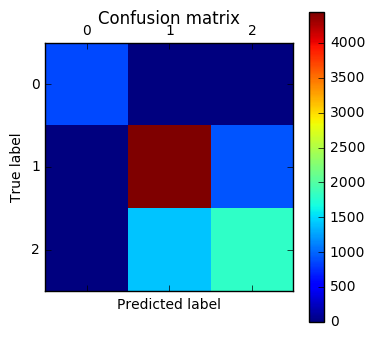

In [150]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [151]:
rf.classes_

array(['KICK', 'PASS', 'RUSH'], dtype=object)